In [1]:
import tensorflow as tf
from tensorflow.keras import initializers, constraints, layers, activations, regularizers
from tensorflow.python.ops import math_ops
from tensorflow.python.keras import backend as K
from tensorflow.python.framework import tensor_shape
from scipy import io as sio
import os
import numpy as np
from numpy.linalg import inv
import warnings
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
%matplotlib inline

# Load Data

In [2]:
def load_HSI(path):
    try:
        data = sio.loadmat(path)
    except NotImplementedError:
        data = h5py.File(path, 'r')
    
    numpy_array = np.asarray(data['Y'], dtype=np.float32)
    numpy_array = numpy_array / np.max(numpy_array.flatten())
    n_rows = data['lines'].item()
    n_cols = data['cols'].item()
    
    if 'GT' in data.keys():
        gt = np.asarray(data['GT'], dtype=np.float32)
    else:
        gt = None
    
    return HSI(numpy_array, n_rows, n_cols, gt)


In [3]:
class HSI:
    def __init__(self, data, rows, cols, gt):
        if data.shape[0] < data.shape[1]:
            data = data.transpose()
            
        self.bands = np.min(data.shape)
        self.cols = cols
        self.rows = rows
        self.image = np.reshape(data,(self.rows,self.cols,self.bands))
        self.gt = gt
    
    def array(self):
        return np.reshape(self.image,(self.rows*self.cols,self.bands))
    
    def get_bands(self, bands):
        return self.image[:,:,bands]

In [4]:
hsi = load_HSI( "Urban4.mat")
data = hsi.array()

In [5]:
# hsi = load_HSI( "Samson.mat")
# data = hsi.array()

In [6]:
hsi.gt.shape

(4, 162)

In [30]:
# fig, axs = plt.subplots(1,3,figsize=(50,15))
# for i in range(num_endmembers):
#     axs[i].set_xlabel('wavelength', fontsize=30)
#     axs[i].set_ylabel('Reflectance', fontsize=30)
#     axs[i].plot(hsi.gt[i,:])


In [54]:
# from scipy.io import loadmat
# annots = loadmat('end3.mat')
# print(annots['M'].shape)

# Parameters to be intialized

In [9]:
#Loss Function used is SAD
def SAD(y_true, y_pred):
    y_true2 = tf.math.l2_normalize(y_true, axis=-1)
    y_pred2 = tf.math.l2_normalize(y_pred, axis=-1)
    A = tf.keras.backend.mean(y_true2 * y_pred2)
    sad = tf.math.acos(A)
    return sad


In [10]:
num_endmembers = 4
num_spectra = 2000
batch_size = 6
learning_rate = 0.001
epochs = 100
loss = SAD
opt = tf.optimizers.RMSprop(learning_rate=learning_rate)

In [11]:
# num_endmembers = 3
# num_spectra = 156
# batch_size = 6
# learning_rate = 0.001
# epochs = 100
# loss = SAD
# opt = tf.optimizers.RMSprop(learning_rate=learning_rate)

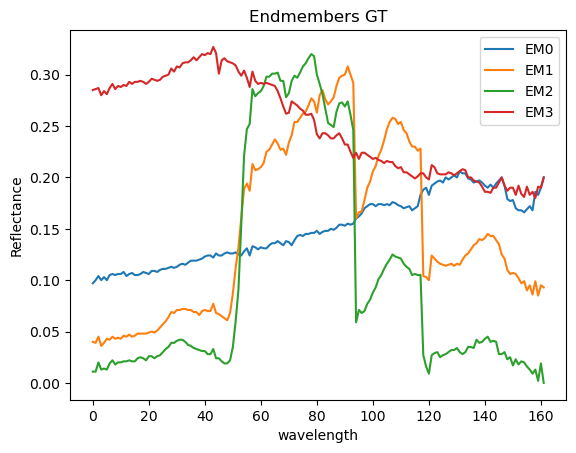

In [13]:
for i in range(num_endmembers):
    plt.title('Endmembers GT')
    plt.xlabel('wavelength', fontsize=10)
    plt.ylabel('Reflectance', fontsize=10)
    plt.plot(hsi.gt[i,:],label=f'EM{i}')
plt.legend()



In [14]:
params = {
    "num_endmembers": num_endmembers,
    "batch_size": batch_size,
    "num_spectra": num_spectra,
    "data": hsi,
    "epochs": epochs,
    "n_bands": hsi.bands,
    "GT": hsi.gt,
    "lr": learning_rate,
    "optimizer": opt,
    "loss": loss,
    "activation":layers.LeakyReLU(0.1)
}

# Autoencoder Model 

In [15]:
class SparseReLU(tf.keras.layers.Layer):
    def __init__(self,params):
        self.params=params
        super(SparseReLU, self).__init__()
        self.alpha = self.add_weight(shape=(self.params['num_endmembers'],),initializer=tf.keras.initializers.Zeros(),
        trainable=True, constraint=tf.keras.constraints.non_neg())
    def build(self, input_shape):
        self.alpha = self.add_weight(shape=input_shape[1:],initializer=tf.keras.initializers.Zeros(),
        trainable=True, constraint=tf.keras.constraints.non_neg())
        super(SparseReLU, self).build(input_shape)
    def call(self, x):
        return tf.keras.backend.relu(x - self.alpha)

In [16]:
class SumToOne(layers.Layer):
    def __init__(self, **kwargs):
        super(SumToOne, self).__init__(**kwargs)
        
    def call(self, x):
        x *= K.cast(x >= K.epsilon(), K.floatx())
        x = K.relu(x)
        x = x/(K.sum(x, axis=-1, keepdims=True)+K.epsilon())
        return x

In [17]:
n_end = params['num_endmembers']
# Input layer
input_ = layers.Input(shape=(params['n_bands'],))
          
encoded = layers.Dense(n_end * 9,params['activation'])(input_)
encoded = layers.Dense(n_end * 6,activation=params['activation'])(encoded)
#encoded = layers.BatchNormalization()(encoded)
encoded = layers.Dense(n_end * 3,activation=params['activation'])(encoded)
#encoded = layers.BatchNormalization()(encoded)
encoded = layers.Dense(n_end,activation=params['activation'])(encoded)

encoded = layers.BatchNormalization()(encoded)

Sparse_ReLU = SparseReLU(params)
encoded = Sparse_ReLU(encoded)

encoded = SumToOne(name='abundances')(encoded)

decoded = layers.GaussianDropout(0.0045)(encoded)

# Decoder
decoded = layers.Dense(params['n_bands'], activation='linear', name='endmembers',use_bias=False,
                       kernel_constraint=constraints.non_neg())(encoded)

model=tf.keras.Model(inputs=input_ , outputs=decoded)

In [20]:
#model.compile(optimizer=params["optimizer"], loss=params["loss"])

In [34]:
model.compile(optimizer=params["optimizer"], loss="mean_squared_error")

# Training the Model

In [35]:
hist=model.fit(x=data,y=data,
            batch_size= params["batch_size"],
            epochs=params["epochs"])

Epoch 1/100
15709/15709 [==============================] - 50s 3ms/step - loss: 0.0018
Epoch 2/100
15709/15709 [==============================] - 50s 3ms/step - loss: 0.0013
Epoch 3/100
15709/15709 [==============================] - 50s 3ms/step - loss: 0.0012
Epoch 4/100
15709/15709 [==============================] - 49s 3ms/step - loss: 0.0012
Epoch 5/100
15709/15709 [==============================] - 49s 3ms/step - loss: 0.0012
Epoch 6/100
15709/15709 [==============================] - 50s 3ms/step - loss: 0.0012
Epoch 7/100
15709/15709 [==============================] - 50s 3ms/step - loss: 0.0012
Epoch 8/100
15709/15709 [==============================] - 50s 3ms/step - loss: 0.0012
Epoch 9/100
15709/15709 [==============================] - 50s 3ms/step - loss: 0.0012
Epoch 10/100
15709/15709 [==============================] - 50s 3ms/step - loss: 0.0012
Epoch 11/100
15709/15709 [==============================] - 50s 3ms/step - loss: 0.0012
Epoch 12/100
15709/15709 [===============

15709/15709 [==============================] - 33s 2ms/step - loss: 0.0013
Epoch 95/100
15709/15709 [==============================] - 30s 2ms/step - loss: 0.0013
Epoch 96/100
15709/15709 [==============================] - 33s 2ms/step - loss: 0.0013
Epoch 97/100
15709/15709 [==============================] - 32s 2ms/step - loss: 0.0013
Epoch 98/100
15709/15709 [==============================] - 32s 2ms/step - loss: 0.0013
Epoch 99/100
15709/15709 [==============================] - 33s 2ms/step - loss: 0.0013
Epoch 100/100
15709/15709 [==============================] - 30s 2ms/step - loss: 0.0013


Text(0, 0.5, 'Loss')

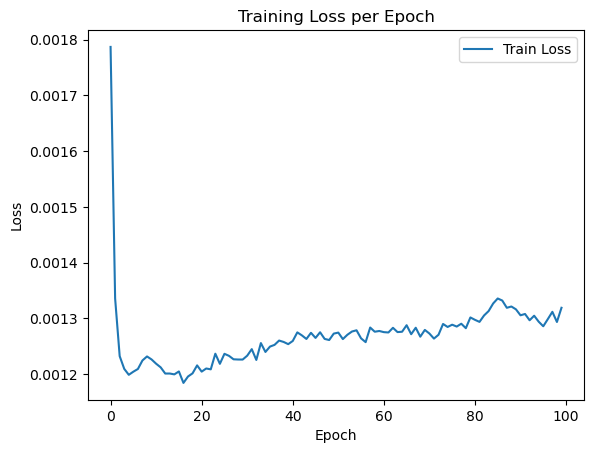

In [36]:
# Plot the model loss on training data
import matplotlib.pyplot as plt
f, ax = plt.subplots()
ax.plot(hist.history['loss'], )
ax.legend(['Train Loss'])
ax.set_title('Training Loss per Epoch')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss') 

# Abundance MAps

In [37]:
def get_endmembers(model):
    return model.layers[len(model.layers) - 1].get_weights()[0]

def get_abundances(model):
    intermediate_layer_model = tf.keras.Model(inputs=model.input, outputs=model.get_layer("abundances").output)
    abundances = intermediate_layer_model.predict(params['data'].array())
    abundances = np.reshape(abundances,[params['data'].cols,params['data'].rows,params['num_endmembers']])
    return abundances

In [38]:
endmembers = get_endmembers(model)
abundances = get_abundances(model)


2946/2946 [==============================] - 4s 1ms/step


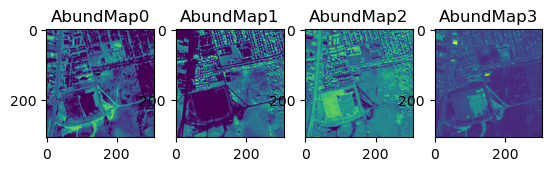

In [39]:
for i in range(num_endmembers):
    #plt.figure(figsize=(10,6))
    plt.subplot(1,num_endmembers,i+1)
    plt.title(f'AbundMap{i}')
    plt.imshow(np.array(abundances[:,:,i]))

# Performance Analysis

In [40]:
def order_endmembers(endmembers, endmembersGT):
    num_endmembers = endmembers.shape[0]
    mydict = {}
    sad_mat = np.ones((num_endmembers, num_endmembers))
    for i in range(num_endmembers):
        endmembers[i, :] = endmembers[i, :] / endmembers[i, :].max()
        endmembersGT[i, :] = endmembersGT[i, :] / endmembersGT[i, :].max()
    for i in range(num_endmembers):
        for j in range(num_endmembers):
            sad_mat[i, j] = numpy_SAD(endmembers[i, :], endmembersGT[j, :])
    rows = 0
    while rows < num_endmembers:
        minimum = sad_mat.min()
        index_arr = np.where(sad_mat == minimum)
        if len(index_arr) < 2:
            break
        index = (index_arr[0][0], index_arr[1][0])
        if index[0] in mydict.keys():
            sad_mat[index[0], index[1]] = 100
        elif index[1] in mydict.values():
            sad_mat[index[0], index[1]] = 100
        else:
            mydict[index[0]] = index[1]
            sad_mat[index[0], index[1]] = 100
            rows += 1
    ASAM = 0
    num = 0
    for i in range(num_endmembers):
        if np.var(endmembersGT[mydict[i]]) > 0:
            ASAM = ASAM + numpy_SAD(endmembers[i, :], endmembersGT[mydict[i]])
            num += 1

    return mydict, ASAM / float(num)

def numpy_SAD(y_true, y_pred):
    cos = y_pred.dot(y_true) / (np.linalg.norm(y_true) * np.linalg.norm(y_pred))
    if cos>1.0: cos = 1.0
    return np.arccos(cos)

In [41]:
hat, sad =order_endmembers(endmembers, hsi.gt)
"mSAD: " + format(sad, '.3f') + " radians"

'mSAD: 0.201 radians'

# 0.153-SAD

# 0.201-MSE

In [56]:
# for i in range(num_endmembers):
#     plt.title('Endmembers GT')
#     plt.xlabel('wavelength', fontsize=10)
#     plt.ylabel('Reflectance', fontsize=10)
#     plt.plot(hsi.gt[3,:],label=f'EM{i}')
#     plt.plot(endmembers[3,:])
# plt.legend()

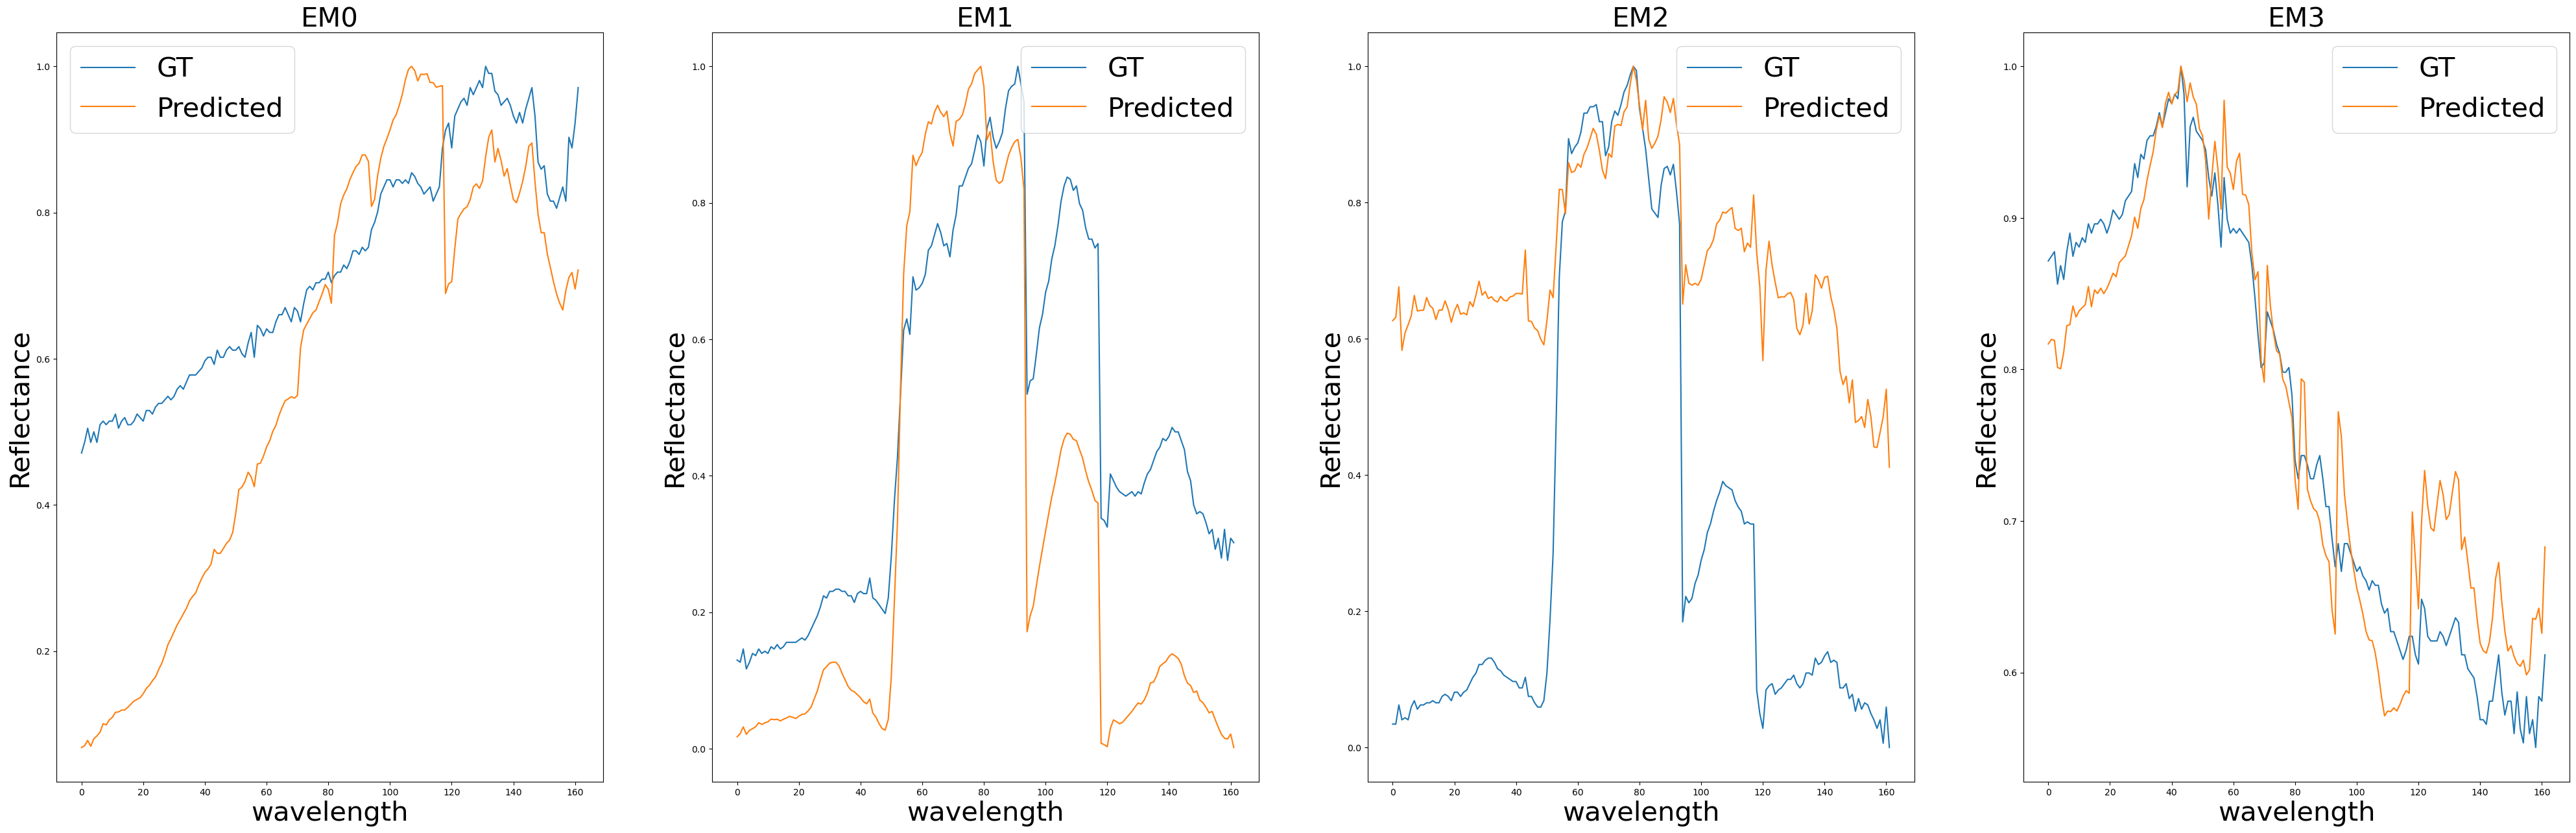

In [55]:
fig, axs = plt.subplots(1,4,figsize=(50,15))
for i in range(num_endmembers):
    axs[i].set_title(f'EM{i}', fontsize=30)
    axs[i].set_xlabel('wavelength', fontsize=30)
    axs[i].set_ylabel('Reflectance', fontsize=30)
    axs[i].plot(hsi.gt[i,:],label='GT')
    axs[i].plot(endmembers[i,:],label='Predicted')
    axs[i].legend(fontsize=30)
